In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np


In [25]:

# Separate classifications of “return to normal” will be created for taste and for smell.
# We will a) perform survival analysis for chemosensory long haulers, using time in days between the date of onset of initial symptoms and the completion day of the follow-up survey.
# We will also b) use linear regression to predict the difference score using the degree of loss in an initial survey and in a follow-up survey, controlling for time passed between the two surveys.

# data = pd.read_csv(r'C:/Users/bicers/gccr003_data.csv',sep=';',encoding='unicode_escape')
data = pd.read_csv(r'C:\Users\tom3r\OneDrive\Desktop\GCCR/gccr003_data.csv',sep=';',encoding= 'unicode_escape')

data["Date_of_onset"] = pd.to_datetime(data["Date_of_onset"], dayfirst=True)
data["Email_Time_Stamp_y"] = pd.to_datetime(data["Email_Time_Stamp_y"], dayfirst=True)

data = data.dropna(subset=['Date_of_onset', 'Email_Time_Stamp_y'])
data['DurationInDays'] = ((data['Email_Time_Stamp_y'] - data['Date_of_onset']).dt.total_seconds() / (60 * 60 * 24))

data = data[data['Date_of_onset'].dt.year > 2018] # Include data after COVID

data.info()
data.describe()
data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3052 entries, 0 to 3391
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Sample_Set_Number_x   3052 non-null   int64         
 1   Date_of_onset         3052 non-null   datetime64[ns]
 2   DurationInDays        3052 non-null   float64       
 3   Smell_before_illness  3020 non-null   float64       
 4   Smell_during_illness  3029 non-null   float64       
 5   Smell_after_illness   2613 non-null   float64       
 6   Smell_current         2960 non-null   float64       
 7   Taste_before_illness  3034 non-null   float64       
 8   Taste_during_illness  3044 non-null   float64       
 9   Taste_after_illness   2620 non-null   float64       
 10  Taste_current         2943 non-null   float64       
 11  Email_Time_Stamp_y    3052 non-null   datetime64[ns]
 12  Status                3052 non-null   int64         
dtypes: datetime64[ns](

,Sample_Set_Number_x,Date_of_onset,DurationInDays,Smell_before_illness,Smell_during_illness,Smell_after_illness,Smell_current,Taste_before_illness,Taste_during_illness,Taste_after_illness,Taste_current,Email_Time_Stamp_y,Status
0,1996,2020-03-14,194.604861,89.5,4.8,9.1,31.0,93.4,9.1,20.9,33.7,2020-09-24 14:31:00,0
1,875,2020-03-26,182.605556,99.1,0.3,34.4,29.9,99.7,46.2,24.4,NaN,2020-09-24 14:32:00,0
2,5862,2020-04-08,169.606250,98.1,99.8,0.0,47.5,100.0,100.0,0.0,48.5,2020-09-24 14:33:00,0
3,5321,2020-03-05,203.608333,100.0,0.0,65.0,99.6,86.4,4.0,72.0,88.1,2020-09-24 14:36:00,0
4,4225,2020-04-02,175.609028,98.5,0.6,NaN,100.0,98.5,0.0,NaN,100.0,2020-09-24 14:37:00,0


In [26]:
# create new dataframe variables
smell_df = data[['DurationInDays', 'Smell_before_illness', 'Smell_current', 'Status']]
taste_df = data[['DurationInDays', 'Taste_before_illness', 'Taste_current', 'Status']]


In [27]:
# drop nan records
smell_df = smell_df.dropna()
taste_df = taste_df.dropna()


In [28]:
# Individuals who reported severe chemosensory dysfunction pre-COVID (i.e., before illness rating <50 for “before illness rating” on the original survey) will be excluded.
smell_df = smell_df[smell_df['Smell_before_illness'] >= 50]
taste_df = taste_df[taste_df['Taste_before_illness'] >= 50]


In [29]:
# calculate recovery percentages
smell_df['percentage_recovery'] = smell_df['Smell_current'] / smell_df['Smell_before_illness'] * 100
taste_df['percentage_recovery'] = taste_df['Taste_current'] / taste_df['Taste_before_illness'] * 100


In [30]:
# Individuals who do not have a follow upt rating that is at least 80% of their pre-illness function rating will be classified as chemosensory long-haulers.
# Status is 0 for normal, 1 for long-haulers
smell_df.loc[smell_df['percentage_recovery'] >= 80, 'Status'] = 0
smell_df.loc[smell_df['percentage_recovery'] < 80, 'Status'] = 1
taste_df.loc[taste_df['percentage_recovery'] >= 80, 'Status'] = 0
taste_df.loc[taste_df['percentage_recovery'] < 80, 'Status'] = 1


In [31]:

smell_df["Status"] = smell_df["Status"].astype('bool')
taste_df["Status"] = taste_df["Status"].astype('bool')


In [32]:
# study for smell
smell_X = smell_df[['DurationInDays']]
smell_y = smell_df['Smell_current'] - smell_df['Smell_before_illness']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(smell_X, smell_y, test_size=0.2)
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coefficients: 
 [0.00919476]


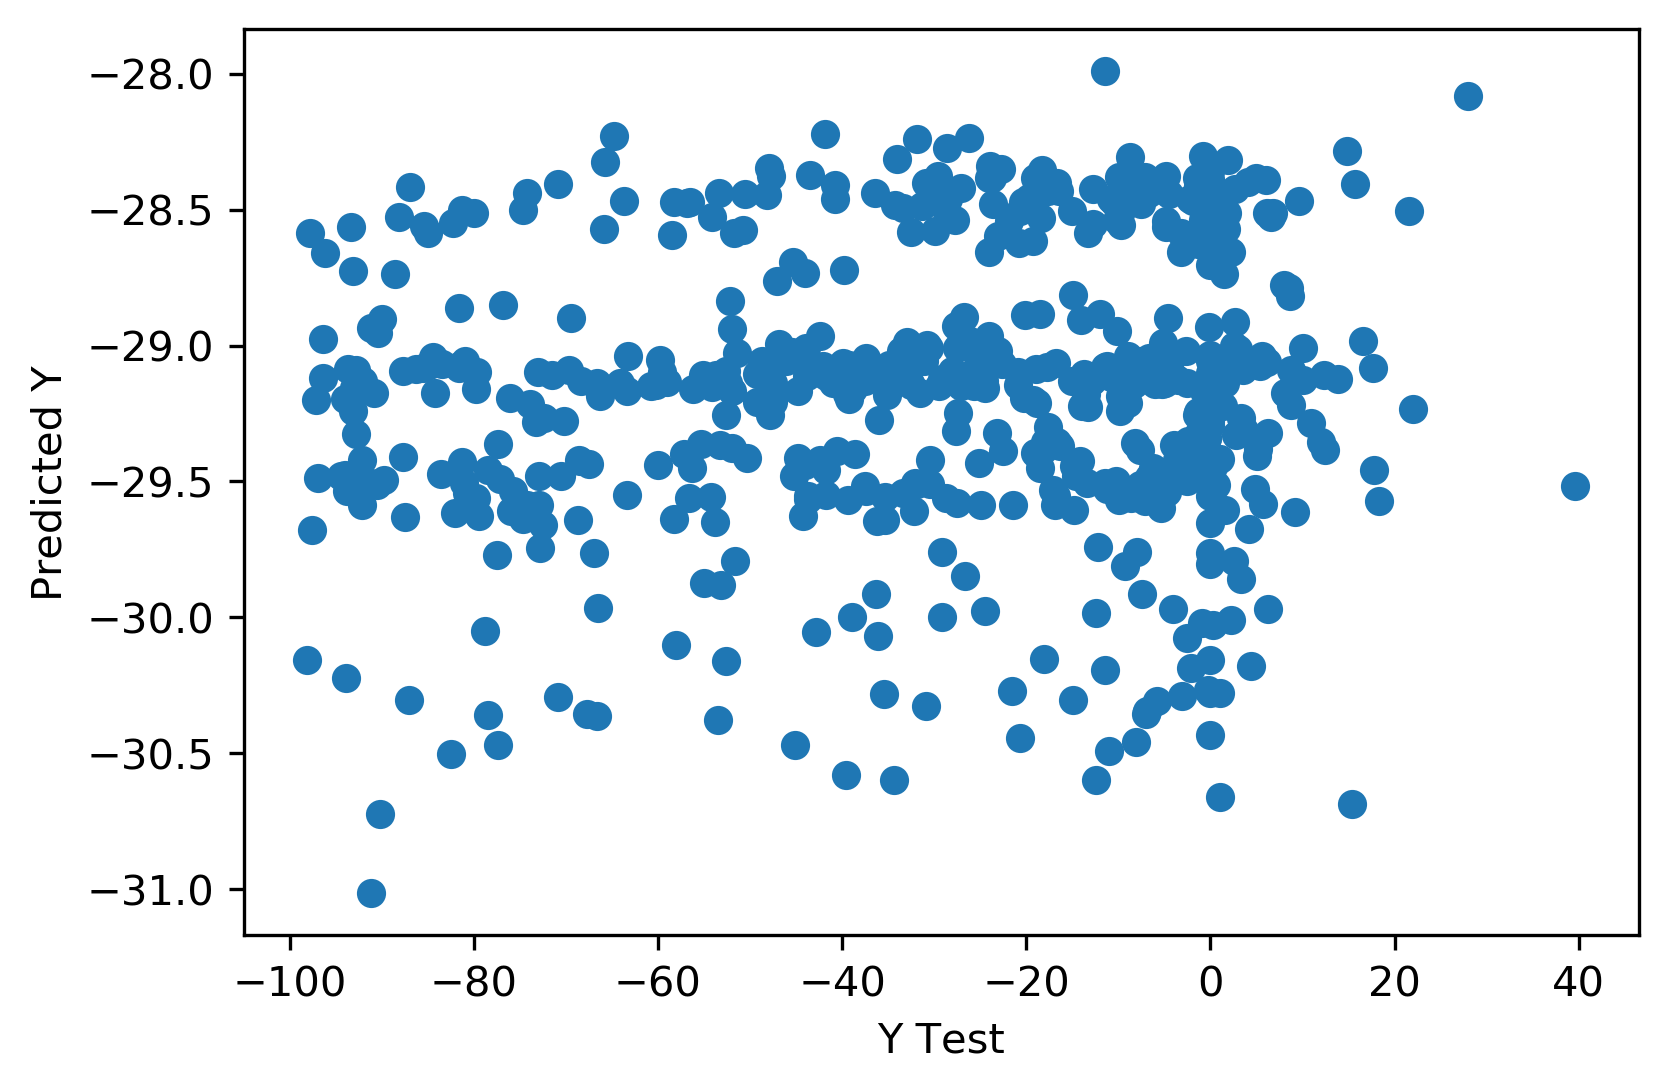

In [34]:
print('Coefficients: \n', lm.coef_)
predictions = lm.predict(X_test)
plt.figure(dpi=300)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


In [35]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


MAE: 26.070422598492836
MSE: 972.7056298240466
RMSE: 31.188229026734536


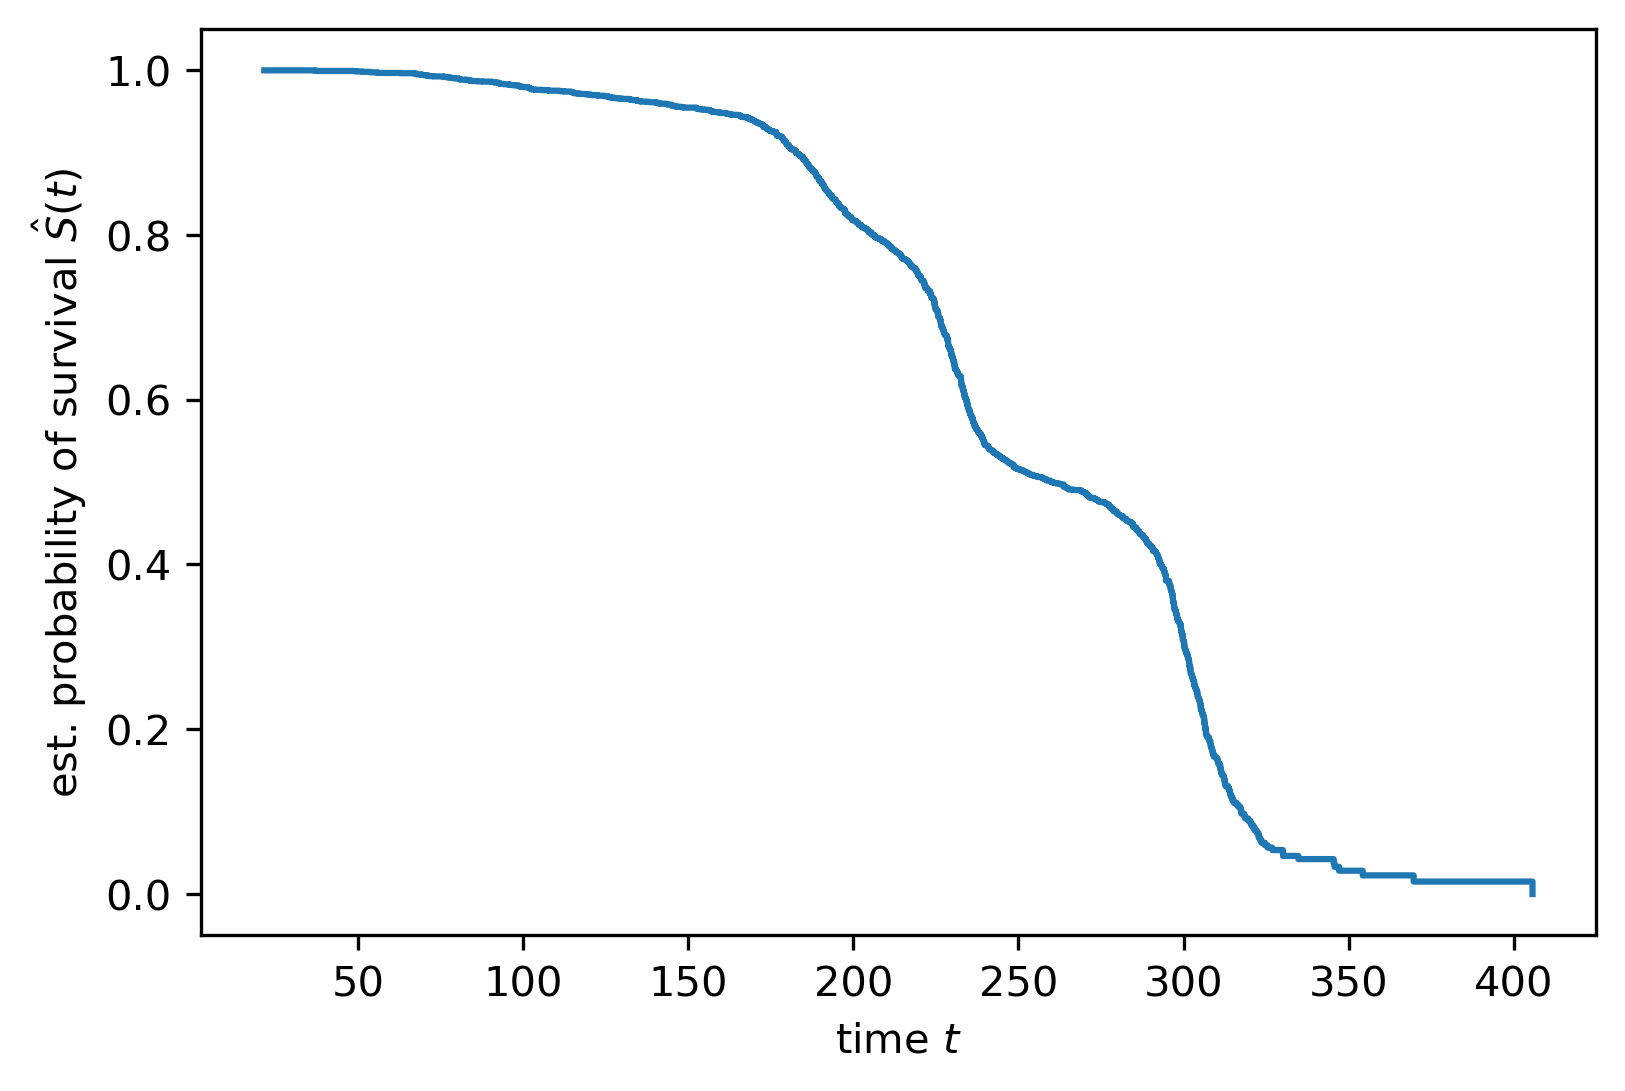

In [39]:
from sksurv.nonparametric import kaplan_meier_estimator
time, survival_prob = kaplan_meier_estimator(smell_df["Status"], smell_df["DurationInDays"])
plt.figure(dpi=300)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()


In [40]:

# study for taste
taste_X = taste_df[['DurationInDays']]
taste_y = taste_df['Taste_current'] - taste_df['Taste_before_illness']


In [41]:
X_train, X_test, y_train, y_test = train_test_split(taste_X, taste_y, test_size=0.2)
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Coefficients: 
 [0.00953829]


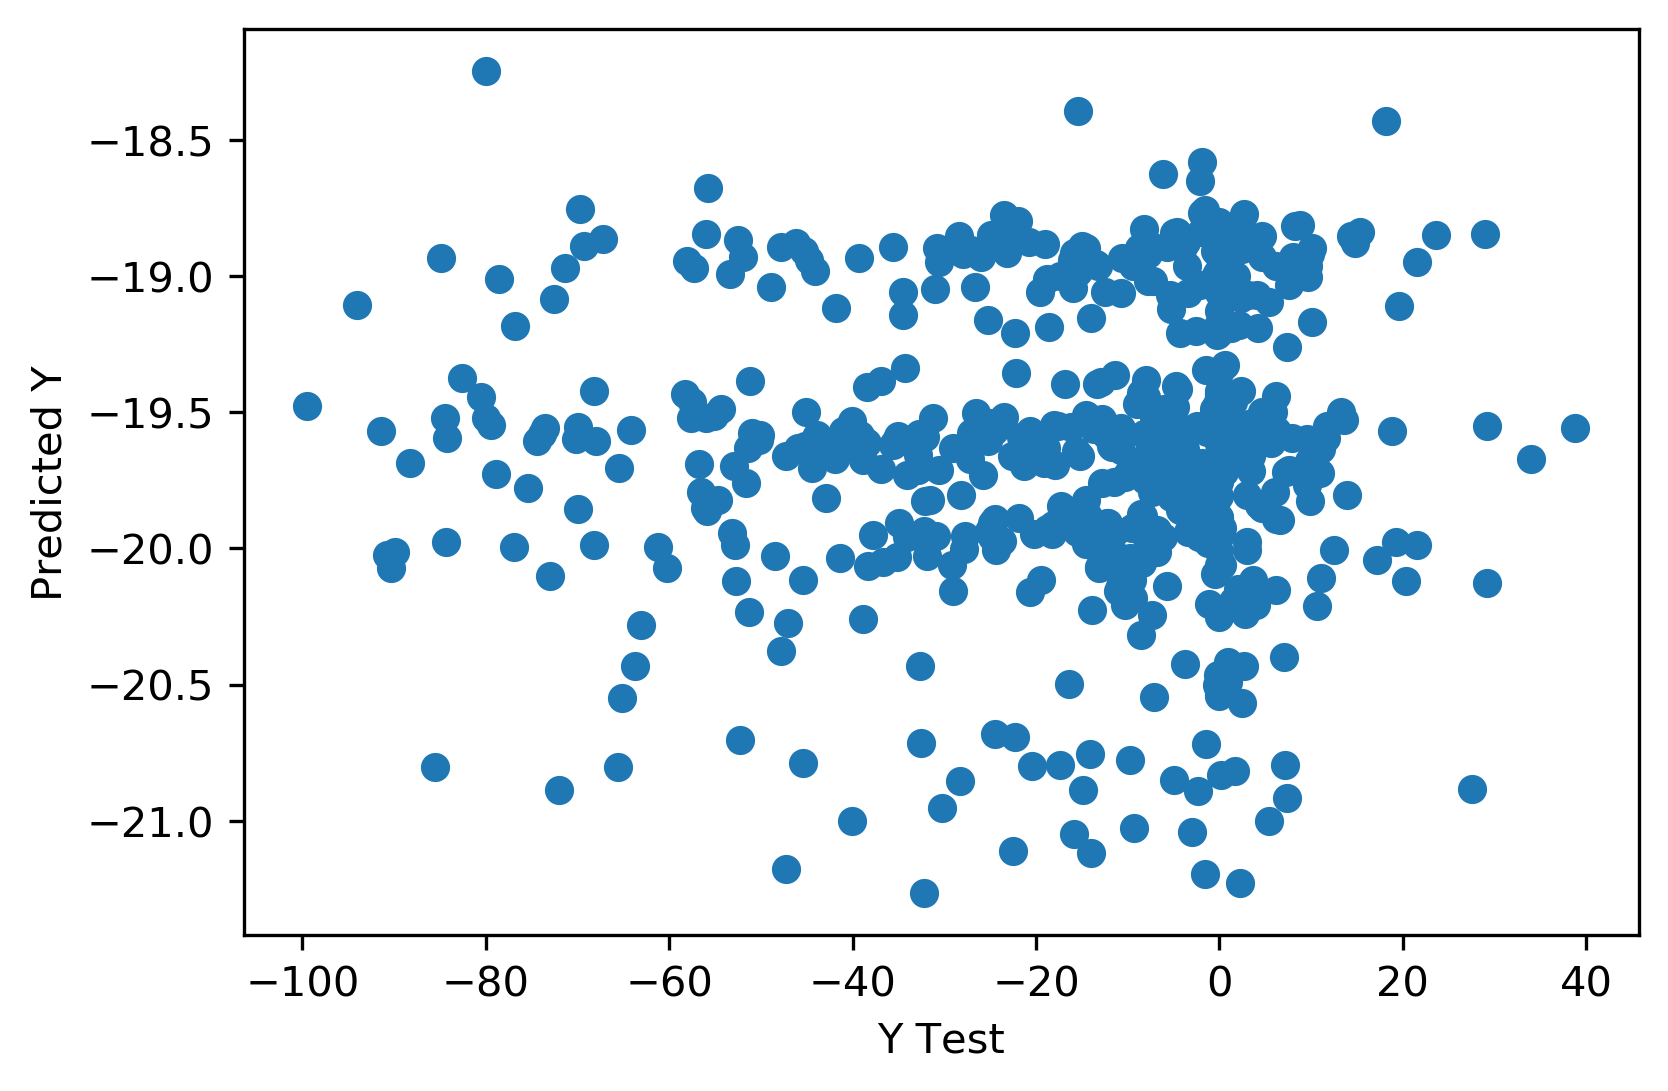

In [42]:
print('Coefficients: \n', lm.coef_)
predictions = lm.predict(X_test)
plt.figure(dpi=300)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


In [43]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


MAE: 20.404103555278432
MSE: 626.9051706819115
RMSE: 25.038074420408442


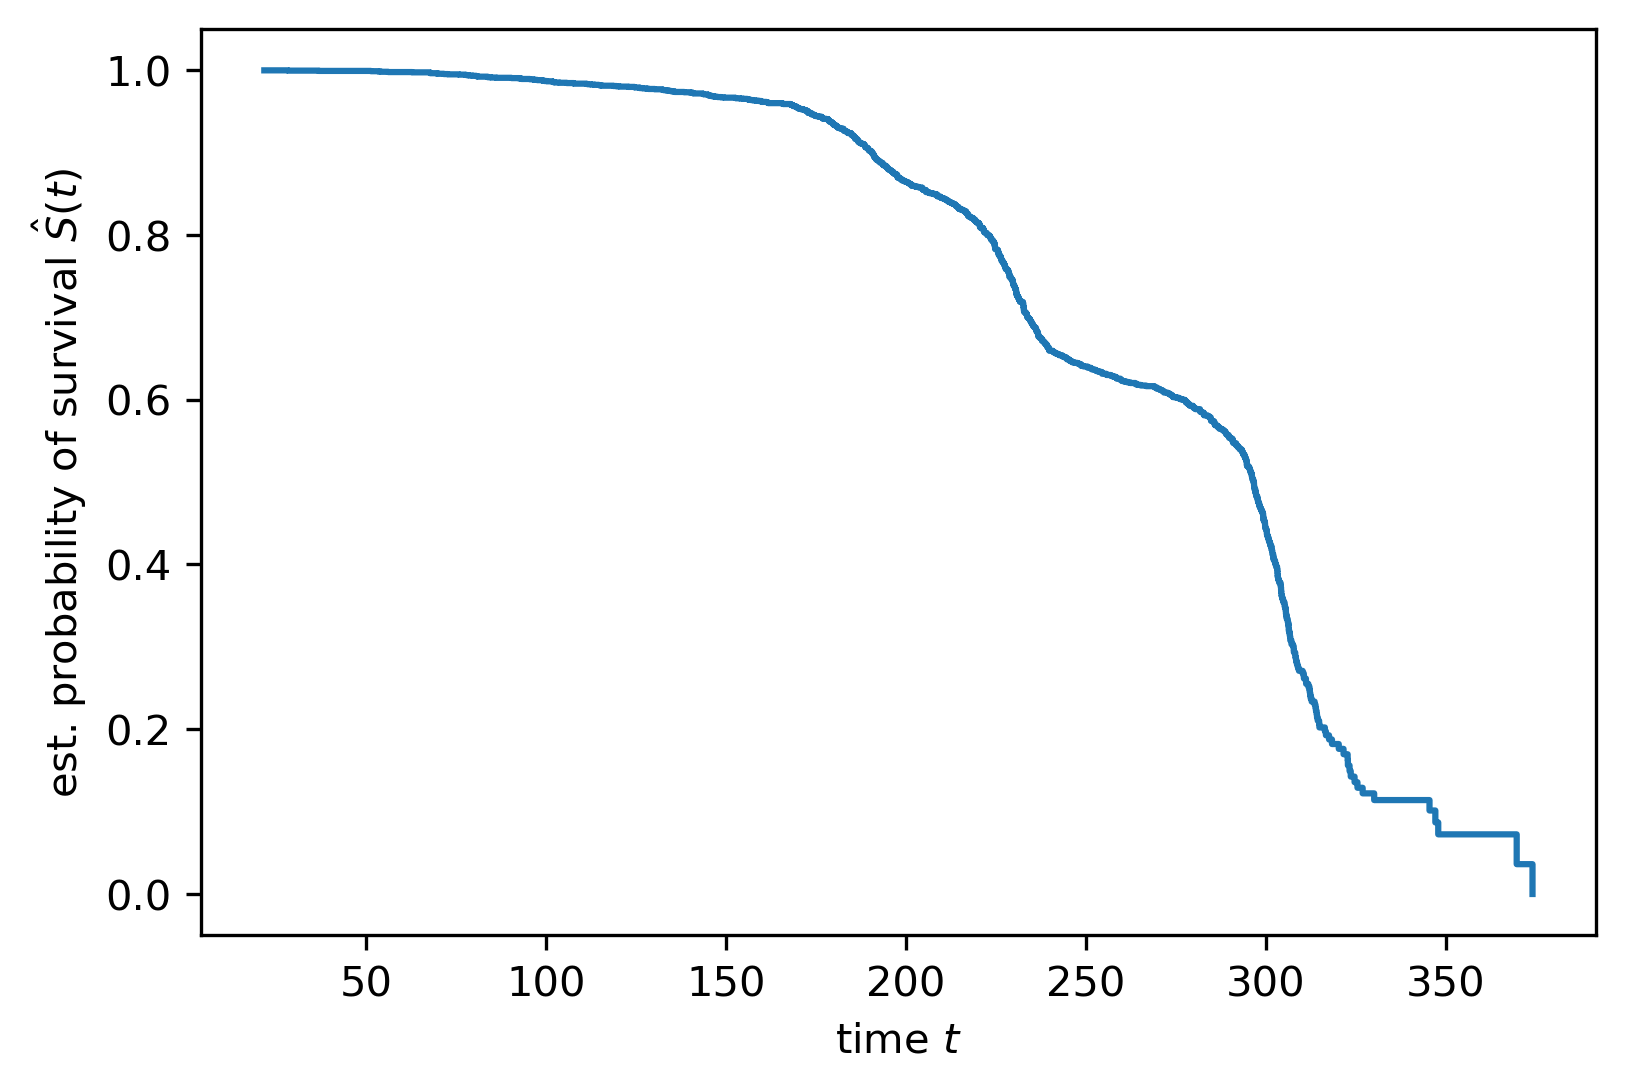

In [45]:
time, survival_prob = kaplan_meier_estimator(taste_df["Status"], taste_df["DurationInDays"])
plt.figure(dpi=300)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()